## Installation and Imports

In [ ]:
!pip install sunpy==3.1.0
!pip install git+https://github.com/RobertJaro/InstrumentToInstrument.git
!pip uninstall deepem -y
!pip install git+https://github.com/RobertJaro/DeepEM.git

In [1]:
# imports for download
import os
import shutil
import drms
from datetime import datetime, timedelta

# DEM tool
from dem.train.model import DeepEM
from dem.train.generator import prep_map
from dem.train.callback import sdo_cmaps

# data processing
import numpy as np
from skimage.measure import block_reduce
from astropy import units as u
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames

# visualization
from sunpy.map import Map
from matplotlib import pyplot as plt
from astropy.visualization import ImageNormalize, AsinhStretch

# file zip
import gzip
import glob

## Download Data

In [2]:
#@title Download Settings
download_dir = 'sdo_data' #@param {type:"string"}

#@markdown Downloading data requires an active registration at JSOC. http://jsoc.stanford.edu/ajax/register_email.html (free of charge)
email = 'robert.jarolim@uni-graz.at' #@param {type:"string"}

# initialize the download client and directories
wls = ['94', '131', '171', '193', '211', '335']
[os.makedirs(os.path.join(download_dir, wl), exist_ok=True) for wl in wls]
client = drms.Client(email=email, verbose=True)

In [3]:
#@title Start Time
year = 2014 #@param {type:"integer"}
month = 1 #@param {type:"integer"}
day = 1 #@param {type:"integer"}
hour = 18 #@param {type:"integer"}
minute = 35 #@param {type:"number"}
# create datetime object
start_date = datetime(year, month, day, hour, minute)


In [4]:
#@title End Time
year = 2014 #@param {type:"integer"}
month = 1 #@param {type:"integer"}
day = 1 #@param {type:"integer"}
hour = 18 #@param {type:"integer"}
minute = 55 #@param {type:"number"}
# create datetime object
end_date = datetime(year, month, day, hour, minute)

In [5]:
cadence = '5m' #@param {type:"string"}

In [7]:
duration = (end_date - start_date) // timedelta(minutes=1)
r = client.export('aia.lev1_euv_12s[%s/%dm@%s][%s]{image}' % (start_date.isoformat('T'), duration, cadence, ','.join(wls) ))
r.wait()

downloaded_files = r.download(download_dir)
for f in downloaded_files.download:
  path_elements = os.path.basename(f).split('.')
  f_date = path_elements[2]
  wl = path_elements[3]
  shutil.move(f, os.path.join(download_dir, wl, f_date[:-1] + '.fits'))

    record: aia.lev1_euv_12s[2014-01-01T18:35:01Z][94]{image_lev1}
  filename: image_lev1.fits
  -> sdo_data/aia.lev1_euv_12s.20140101T183501Z.94.image_lev1.fits
    record: aia.lev1_euv_12s[2014-01-01T18:35:01Z][131]{image_lev1}
  filename: image_lev1.fits
  -> sdo_data/aia.lev1_euv_12s.20140101T183501Z.131.image_lev1.fits
    record: aia.lev1_euv_12s[2014-01-01T18:35:01Z][171]{image_lev1}
  filename: image_lev1.fits
  -> sdo_data/aia.lev1_euv_12s.20140101T183501Z.171.image_lev1.fits
    record: aia.lev1_euv_12s[2014-01-01T18:35:01Z][193]{image_lev1}
  filename: image_lev1.fits
  -> sdo_data/aia.lev1_euv_12s.20140101T183501Z.193.image_lev1.fits
    record: aia.lev1_euv_12s[2014-01-01T18:35:01Z][211]{image_lev1}
  filename: image_lev1.fits
  -> sdo_data/aia.lev1_euv_12s.20140101T183501Z.211.image_lev1.fits
    record: aia.lev1_euv_12s[2014-01-01T18:35:01Z][335]{image_lev1}
  filename: image_lev1.fits
  -> sdo_data/aia.lev1_euv_12s.20140101T183501Z.335.image_lev1.fits
    record: aia.le

## Compute DEM maps

Initialize model for estimating the DEM maps.

In [6]:
dem_model = DeepEM()

Compute the DEM maps for a single observation.

In [10]:
# select the first observation
files = [sorted(glob.glob(os.path.join(download_dir, wl, '*.fits')))[0] for wl in wls]

# load maps and data
maps = [prep_map(Map(f), recenter=True) for f in files]
image = np.array([s_map.data for s_map in maps])

In [19]:
dem, reconstruction = dem_model.compute_patches(image, block_shape=(512, 512), return_reconstruction=True, bin=(1, 2, 2), temperature_range=(5,8))

Visualize the results.

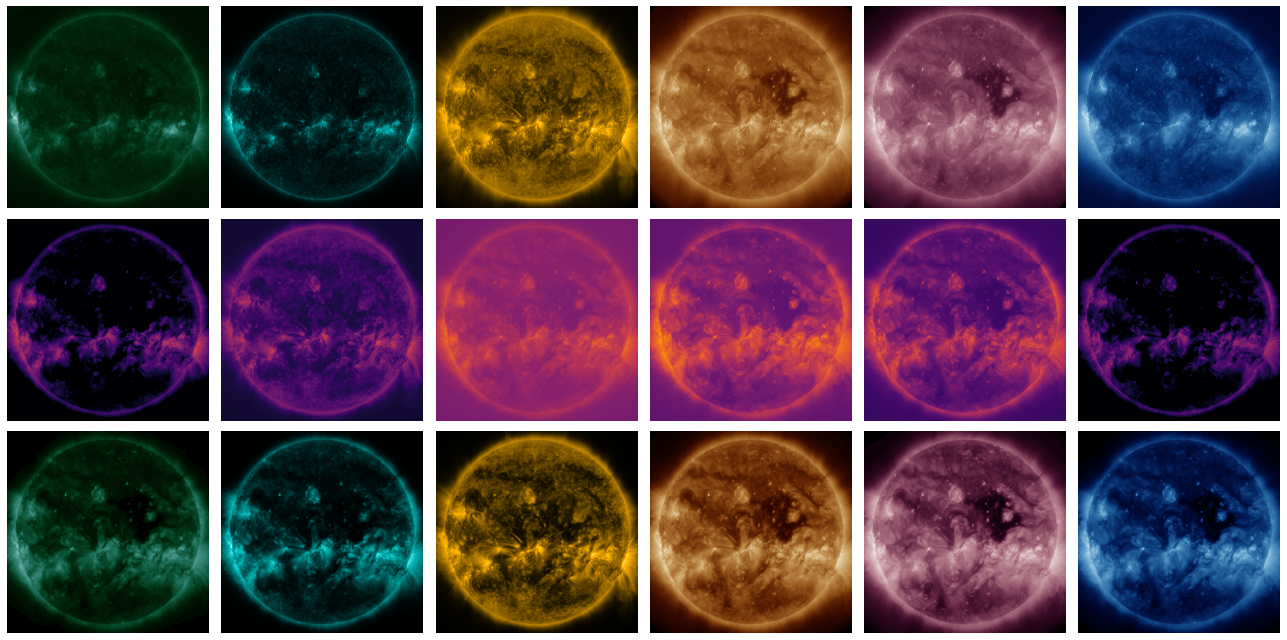

In [35]:
# sum temperature bins
sum_dem = block_reduce(dem, (10, 1, 1))

fig, axs = plt.subplots(3, image.shape[0], figsize=(image.shape[0] * 3, 9))
[ax.set_axis_off() for ax in np.ravel(axs)]
for i, (ax, cmap) in enumerate(zip(axs[0], sdo_cmaps)):
    ax.imshow(image[i], cmap=cmap, norm=ImageNormalize(stretch=AsinhStretch(0.005)), origin='lower')
for i, ax in enumerate(axs[1]):
    ax.imshow(sum_dem[i], origin='lower', cmap='inferno', vmin=1000, vmax=1200)
for i, (ax, cmap) in enumerate(zip(axs[2], sdo_cmaps)):
    ax.imshow(reconstruction[i], cmap=cmap, norm=ImageNormalize(stretch=AsinhStretch(0.005)), origin='lower')
plt.tight_layout()
plt.show()

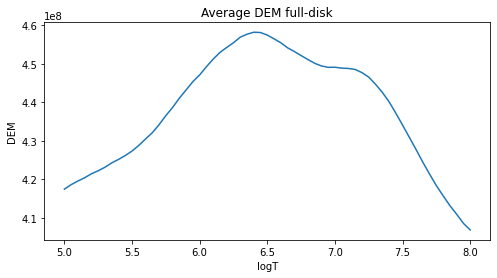

In [36]:
plt.figure(figsize=(8, 4))
plt.plot(np.arange(5, 8.01, 0.05), dem.sum((1, 2)))
plt.xlabel('logT')
plt.ylabel('DEM')
plt.title('Average DEM full-disk')
plt.show()

## Sequentially processing files

In [ ]:
wl_files = [sorted(glob.glob(os.path.join(download_dir, wl, '*.fits'))) for wl in wls]

dems = dem_model.icompute(wl_files, bin=(1, 4, 4), num_workers=1)
log_T = np.arange(4, 9.01, 0.05)

for i, dem in enumerate(dems):
  temp = np.sum(dem * log_T[:, None, None], axis=0) / np.sum(dem, axis=0)
  print(np.min(temp), np.max(temp))
  # plot image
  plt.figure(figsize=(4, 4))
  plt.imshow(temp, cmap='inferno', origin='lower')
  plt.axis('off')
  plt.show()
  # plot average dem
  plt.figure(figsize=(4, 2))
  plt.plot(log_T, dem.sum((1, 2)))
  plt.xlabel('logT')
  plt.ylabel('DEM')
  plt.title('Average DEM full-disk')
  plt.show()

## Working with cut-outs

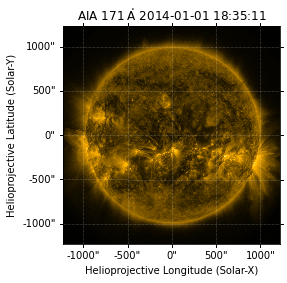

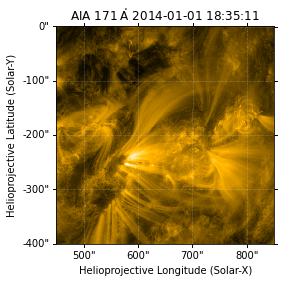

In [44]:
bl = SkyCoord(450 * u.arcsec, 0 * u.arcsec, obstime=start_date, observer='earth', frame=frames.Helioprojective)
tr = SkyCoord(850 * u.arcsec, -400 * u.arcsec, obstime=start_date, observer='earth', frame=frames.Helioprojective)

wl_files = [sorted(glob.glob(os.path.join(download_dir, wl, '*.fits'))) for wl in wls]
wl_files = np.array(wl_files)

# plot full-disk
Map(wl_files[2, 0]).plot()
plt.show()
# plot example
Map(wl_files[2, 0]).submap(bottom_left=bl, top_right=tr).plot()
plt.show()

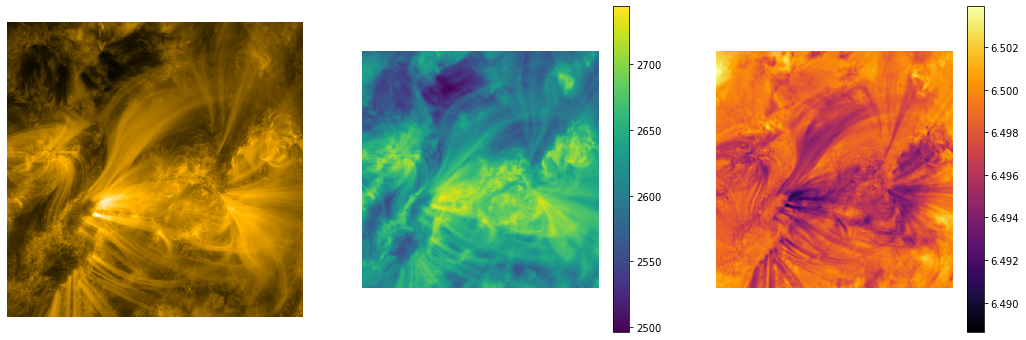

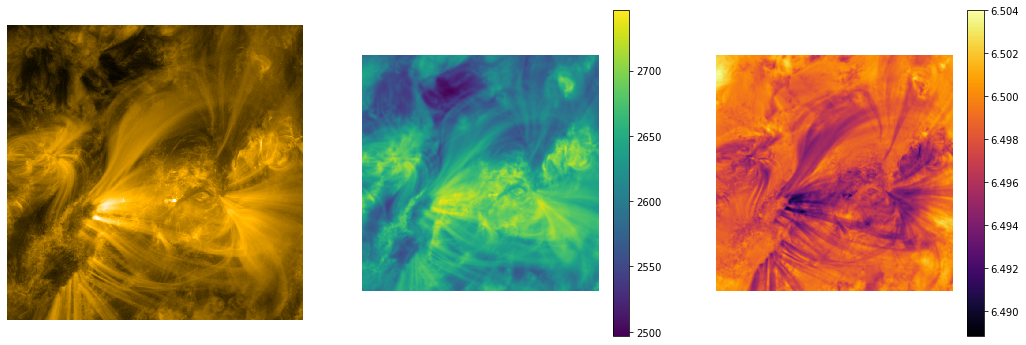

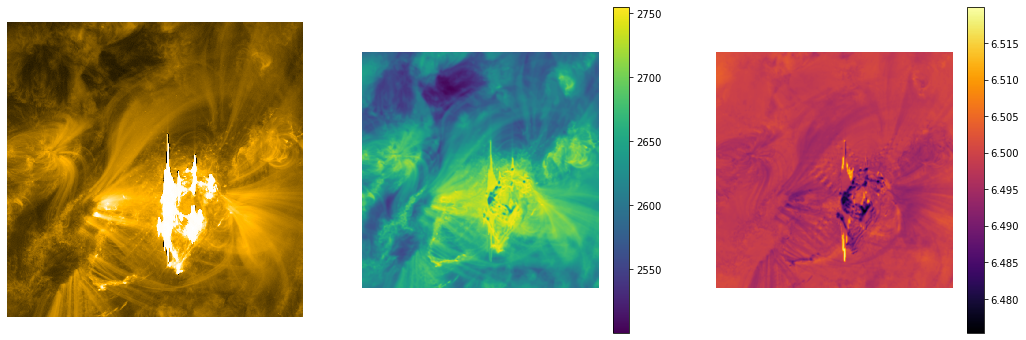

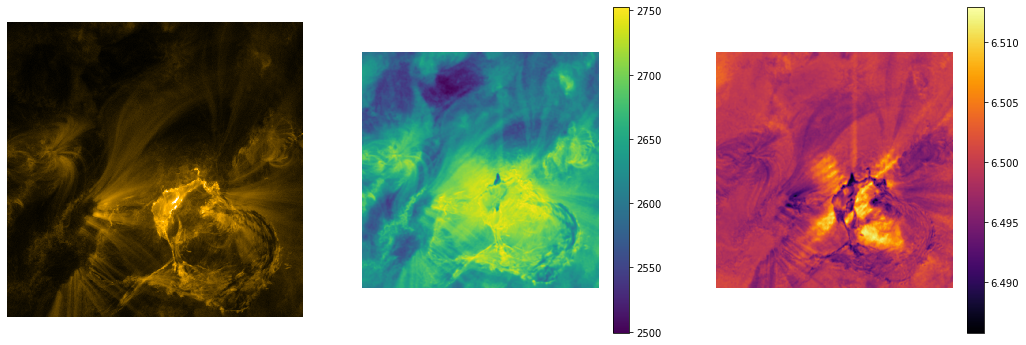

In [55]:
log_T = np.arange(4, 9.01, 0.05)

for files in wl_files.transpose():
  maps = [prep_map(Map(f).submap(bottom_left=bl, top_right=tr)) for f in files]

  images = np.array([s_map.data for s_map in maps])
  # fix shape of submaps
  min_y, min_x = np.min([img.shape[0] for img in images]), np.min([img.shape[1] for img in images])
  images = [img[:min_y, :min_x] for img in images]

  image = np.array(images)

  dem = dem_model.compute(image, return_reconstruction=False)
  temp = np.sum(dem * log_T[:, None, None], axis=0) / np.sum(dem, axis=0)
  fig, axs = plt.subplots(1, 3, figsize=(18, 6))
  [ax.set_axis_off() for ax in axs]
  axs[0].imshow(maps[2].data, **maps[2].plot_settings)
  pos = axs[1].imshow(np.sum(dem, 0), origin='lower')
  fig.colorbar(pos, ax=axs[1])
  pos = axs[2].imshow(temp, cmap='inferno', origin='lower')
  fig.colorbar(pos, ax=axs[2])
  plt.show()